# Assignment A6a: Find Data

In this assignment, we apply basic functions to explore and filter the data in a shape file, functions, and methods like *buffer*, *intersects* and *within* to solve the use cases. Also, we use libraries like geopanda, shapely and pyproj.

## Prerequisites

Install geopanda library with *pip install*. See [detailed instructions](https://geopandas.org/en/stable/getting_started/install). 



In [4]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 88.1 MB/s eta 0:00:00


Load shape file *stm_arrets_sig* (stops) and *stm_lignes_sig.shp* (routes). This dataset contains geospatial information of the routes and stops of the bus and metro lines of the Société de transport de Montréal. Download dataset [Here](https://open.canada.ca/data/en/dataset/a0073997-3a02-4c34-8acf-758a2ee950f4). 

## Find Data in Shape File

Import geopandas library, and read the shape file with function read_file(), this return a GeoDataFrame into variable stmArretsSig. 


In [73]:
# import the geopandas class
import geopandas

# read shape file from path file
stmArretsSig = geopandas.read_file("/content/stm_arrets_sig.shp")  

Show geodataframe data table with function head().

In [74]:
# explore data
stmArretsSig.head()

,stop_id,stop_code,stop_name,stop_url,wheelchair,route_id,loc_type,service_id,geometry
0,43-01,10118,Station Angrignon,NaN,2,NaN,2,22U,POINT (296677.562 5034048.338)
1,43,10118,Station Angrignon,http://www.stm.info/fr/infos/reseaux/metro/ang...,2,1,0,22U,POINT (296733.669 5034064.602)
2,42-01,10120,Station Monk - Édicule Nord (B),NaN,2,NaN,2,22U,POINT (297515.753 5034601.626)
3,42-02,10120,Station Monk - Édicule Sud (A),NaN,2,NaN,2,22U,POINT (297496.004 5034568.310)
4,42,10120,Station Monk,http://www.stm.info/fr/infos/reseaux/metro/monk,2,1,0,22U,POINT (297506.817 5034585.078)


What is the name of the stop with stop_code = 50117?

Filter GeoDataFrame stmArretsSig by the *stop_code* column with the condition that its value must equal 50117. And print value of *stop_name* column.

In [75]:
#Return all rows with stope_code is equal 50117
stopName = stmArretsSig[stmArretsSig['stop_code'] == 50117]

print("Stop name 50117 is " + stopName['stop_name'])

222    Stop name 50117 is Station Jean-Drapeau
Name: stop_name, dtype: object


## Filter and Count rows

Read the *stm_lignes_sig* file.

In [10]:
stmLignesSig = geopandas.read_file("/content/stm_lignes_sig.shp")  
stmLignesSig.head()

,route_id,headsign,route_name,shape_id,service_id,geometry
0,1,STATION ANGRIGNON,Verte,11072,22U,"LINESTRING (302040.087 5050741.446, 301735.980..."
1,1,STATION HONORÉ-BEAUGRAND,Verte,11071,22U,"LINESTRING (296733.669 5034064.602, 297506.817..."
2,2,STATION CÔTE-VERTU,Orange,20236,22U,"LINESTRING (287432.768 5046526.781, 288453.790..."
3,2,STATION CÔTE-VERTU,Orange,20238,22U,"LINESTRING (291670.183 5046165.402, 292618.193..."
4,2,STATION HENRI-BOURASSA,Orange,20239,22U,"LINESTRING (290521.096 5041607.071, 291141.889..."


How many transit routes exists?

Use the .value_counts method [(see Value counts)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html?highlight=value_counts#pandas.DataFrame.value_counts), which returns the number of occurences of each value in a Series. Then, print the length of the transit routes.

In [76]:
total_routes = len(stmLignesSig['route_id'].value_counts())
print( str(total_routes) + ' Transit routes')

217 Transit routes


## Spatial Filter (Within and Intersect) 

We must find all transit stops within a radius of 1 km from the point with coordinates -73.587519, 45.504840.

### 1. Transformations of Geometric Objects

Import pyproj library to project geometries from WKT string POINT(-73.587519 45.504840).

Create a shapely geometry object, pass the WKT string to the shapely.wkt.loads function.

In [77]:
import pyproj
import shapely.wkt
from shapely.ops import transform
from shapely import Point

POINTSTRING = 'POINT (-73.587519 45.504840)'
point = shapely.wkt.loads(POINTSTRING)

Create two variable to EPSG initial (EPSG:4326) and EPGS final (EPGS:32188) and transform coordinates X,Y the new system. [(See Transformations)](https://shapely.readthedocs.io/en/stable/manual.html#other-transformations)

In [78]:
wgs84 = pyproj.CRS('EPSG:4326')
nd83 = pyproj.CRS('EPSG:32188')

project = pyproj.Transformer.from_crs(wgs84, nd83, always_xy=True).transform
nd83_point = transform(project, point)

nd83_point.coords.xy

(array('d', [297960.95452469634]), array('d', [5040550.255491475]))

### 2. Create a Buffer

Create buffer of 1 kilometer (1000 meter).

In [80]:
pointBuffer = nd83_point.buffer(1000)

### 3. Transit Stops Within Buffer

Use *within* method to return a *Series* of dtype('bool') with value True for each aligned geometry that is within of buffer.

In [81]:
stop_mask = stmArretsSig.within(pointBuffer)
print(stop_mask)

0       False
1       False
2       False
3       False
4       False
        ...  
8939    False
8940    False
8941    False
8942    False
8943    False
Length: 8944, dtype: bool


we have an array of boolean values for each row. Now, we can select point that are inside to the buffer. 

Use *loc* function on stmArretsSig.



In [84]:
transit_stop = stmArretsSig.loc[stop_mask]

How many transit stops are within the buffer area?

In [85]:
len(transit_stop)

42

Visualize transit stops:

<Axes: >

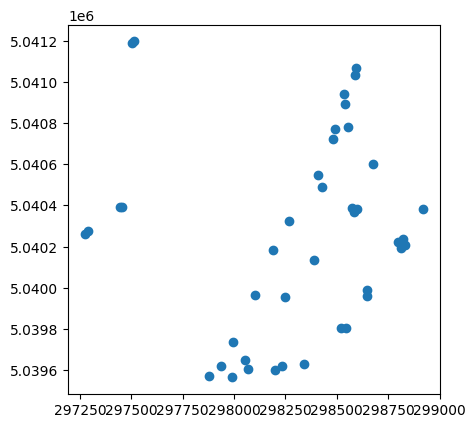

In [86]:
transit_stop.plot()

Which transit routes serves these stops?

Intersect route serves with buffer, then:

In [87]:
route_mask = stmLignesSig.intersects(pointBuffer)

print(route_mask)

0      False
1      False
2      False
3      False
4      False
       ...  
563    False
564    False
565    False
566    False
567    False
Length: 568, dtype: bool


The transit routes serves are:

In [88]:
routes_serves = stmLignesSig.loc[route_mask]
len(routes_serves)

34

Save the transit routes serves to GeoJSON.

In [92]:
routes_serves.to_file("/content/result/routes_serves.geojson", driver='GeoJSON')

# Thank you for taking the time to read